In [ ]:
# MNIST를 이용해 MLP 설계.

In [44]:

import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)


Using Pytorch version :  1.9.0  Device :  cuda


In [45]:
# 1. 하이퍼파라미터
BATCH_SIZE = 32 # Mini-batch 
EPOCHS = 10 
# iteration : 데이터수 / Mini-batch 로 계산. 1개의 MINI-BATCH로 학습하는 횟수.
# 6만/32= 1875번.
# iteration * EPOCH 만큼 반복.

In [46]:
# 2. 데이터 다운로드
train_dataset = datasets.MNIST(root="../data/MNIST",
                               train=True,
                               download=True,
                               transform = transforms.ToTensor())
#train_set download. ToTensor()로 255스칼라값을 데이터를 0~1로 정규화.
#과적화 방지를 위해.
test_dataset = datasets.MNIST(root="../data/MNIST",
                               train=False,
                               download=True,
                               transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True) # 순서가 암기되는것을 막기위해.
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

In [47]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

60000
10000


In [48]:
x_train[1,:,12] # 한 이미지의 12번행
#소수점인데 어떻게 그림으로 나타내나?

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9922, 0.9843, 0.9843, 0.1216,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.4941, 0.8627, 0.9843, 0.9843, 0.3686, 0.0000, 0.0000,
         0.0000]])

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


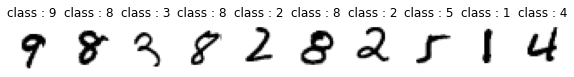

In [49]:
# 2. 데이터 확인
for (x_train, y_train) in train_loader:
    print('x_train:', x_train.size(),'type:',x_train.type())
    print('y_train:', y_train.size(),'type:',y_train.type())
    break # 6만개 데이터중 batch 한개만 확인하려고


pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(x_train[i,:,:].numpy().reshape(28,28),cmap='gray_r')
    plt.title('class : '+str(y_train[i].item()))


In [50]:
# 3. MLP 모델 설계. hidden layer 2개??
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() # nn 모듈의 메소드를 상속받음.
        self.fc1 = nn.Linear(28*28, 512) # 1. input 레이어. 28*28이미지. 512 output 설정.
        self.fc2 = nn.Linear(512,256) #2. hidden 레이어1, 입력으로 512 node.fully connected.
        self.fc3 = nn.Linear(256,10) #3. hidden 레이어2.
        # 10개의 output으로 분류
    def forward(self,x):
        x = x.view(-1,28*28) # x라는 2차원 이미지. 1차원으로 FLATTEN
        x = self.fc1(x) # input 레이어 선형결합. 512개 out
        x = F.sigmoid(x) # 선형결합 결과를 sigmoid->hidden layer
        x = self.fc2(x) # hidden 레이어 선형결합. 256개 out
        x = F.sigmoid(x) # 선형결합 결과를 sigmoid
        x = self.fc3(x) # hidden 레이어를 선형결합. 10개 out
        x = F.log_softmax(x,dim = 1)# softmax 함수로 0~10 분류.
        return x

In [51]:
#4. Optimizer, Loss 함수 설정
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01, momentum = 0.5) # SGD optimizer + momentum
criterion = nn.CrossEntropyLoss() #crossEntropyLoss 함수.
# Label 값이 원-핫 인코딩 값이라서 사용한다.

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


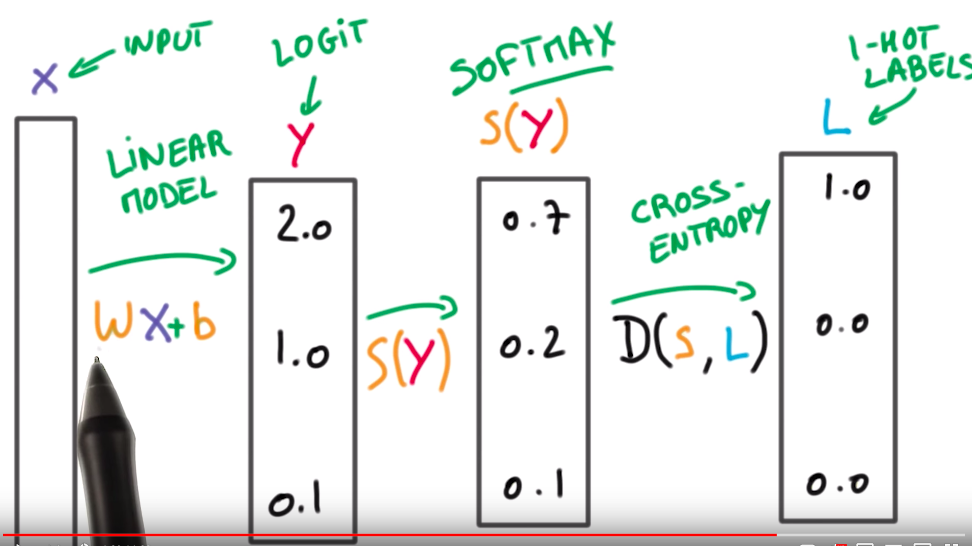

softmax 함수가 총합은 1이되는 score 값을 출력.

그 결과를 one-hot encoding으로 변환

ex) encoding 값
CLASS "1" == [ 0, 1, 0, 0, 0, 0, 0, 0, 0 , 0 ]

결과값과 label(one-hot encoding)을 crossEntropyLoss로 비교.

In [53]:
#5. MLP 모델 학습을 진행하며, 모델 성능을 확인하는 함수
def train(model,train_loader,optimizer,log_interval):
    model.train() #학습상태로 지정
    for batch_idx,(image,label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()#그래디언트 초기화
        output = model(image) #forward 계산
        loss = criterion(output,label)#label과 비교하여 loss계산
        loss.backward()#back propagation
        optimizer.step()#gradient로 파라미터값 업데이트
        
        #이부분 나중에 지우기
        #if batch_idx % log_interval == 10:
        #    print("훈련 epoch : {} [{}/{}({:.0f})%] \t Train Loss: {:.6f}".format(
        #        Epoch,batch_idx*len(image),
        #        len(train_loader.dataset),100.*batch_idx/len(train_loader.dataset),
        #        loss.item()
        #    ))

In [52]:
#6. 학습 중 validation 
def evaluate(model,test_loader):
    model.eval()#평가상태로 지정
    test_loss =0
    correct =0
    
    #no_grad는 학습 시키지 않는다는 선언, gradient가 업데이트x
    with torch.no_grad():
        for image,label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss +=criterion(output,label).item()#batch의 모든이미지의 loss를 합한다.
            prediction = output.max(1,keepdim=True)[1]#10개라벨중 가장큰것
            correct +=prediction.eq(label.view_as(prediction)).sum().item()#비교해서 같으면 더한다.
            #view_as는 데이터 차원 똑같이 맞추기.
    test_loss /= len(test_loader.dataset)#batch안의 loss들의 평균
    test_accuracy = 100. * correct/len(test_loader.dataset)
    return test_loss, test_accuracy

In [54]:
#7. MLP학습을 진행하며 Train,Test set의 loss 및 Test set Accuracy 확인
for Epoch in range(1,EPOCHS+1):
    train(model,train_loader,optimizer,log_interval = 200)
    test_loss, test_accuracy = evaluate(model,test_loader)
    print("\n[EPOCH:{}], \tTest Loss:{:.4f} \tTest Accuracy: {:.2f} %\n".
          format(Epoch,test_loss,test_accuracy))
    


[EPOCH:1], 	Test Loss:0.0696 	Test Accuracy: 23.22 %


[EPOCH:2], 	Test Loss:0.0385 	Test Accuracy: 59.65 %


[EPOCH:3], 	Test Loss:0.0227 	Test Accuracy: 78.29 %


[EPOCH:4], 	Test Loss:0.0172 	Test Accuracy: 84.19 %


[EPOCH:5], 	Test Loss:0.0146 	Test Accuracy: 86.19 %


[EPOCH:6], 	Test Loss:0.0130 	Test Accuracy: 87.98 %


[EPOCH:7], 	Test Loss:0.0121 	Test Accuracy: 88.75 %


[EPOCH:8], 	Test Loss:0.0113 	Test Accuracy: 89.55 %


[EPOCH:9], 	Test Loss:0.0109 	Test Accuracy: 89.88 %


[EPOCH:10], 	Test Loss:0.0106 	Test Accuracy: 90.13 %



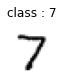

--- 테스트 ---
tensor([[-9.4325e+00, -1.4868e+01, -9.3205e+00, -7.2561e+00, -1.4536e+01,
         -1.0318e+01, -2.0055e+01, -4.6018e-03, -1.1906e+01, -5.6062e+00]],
       device='cuda:0')
tensor([[7]], device='cuda:0')


In [43]:
# test 데이터
pltsize=1
plt.figure(figsize=(20*pltsize,2*pltsize))

with torch.no_grad():
    for image,label in test_loader:
        plt.subplot(2,10,1)
        plt.axis('off')
        plt.imshow(image[0].numpy().reshape(28,28),cmap='gray_r')
        plt.title('class : '+str(label[0].item()))
        plt.show()
        
        image = image[0].to(DEVICE)
        output = model(image)
        print("--- 테스트 ---")
        print(output)#합이 1이 안되는데?(log_softmax)
        #SOFTMAX 값에 LOG를 씌운것.
        prediction = output.max(1,keepdim=True)[1]
        print(prediction)
        
        break